# Acceleration controller

Consider the system of a point body (vehicle) of mass $1$, moving without friction, and controlled by an external force.

The equations of the dynamics are given by

\begin{eqnarray*}
\left(\begin{array}{l}\ddot{x}\\ \ddot{y}\end{array}\right) & = & \gamma(t)
\end{eqnarray*}

$\gamma$ is assumed piecewise constant, with changing points at regular intervals (the control rate). At each changing points, the value of $\gamma$ is acquired from a controller. At regular intervals, the controller has access to the current simulation time $t$ and state of the system $(x,y,\dot{x},\dot{y})$. The controller can thus keep a history of its observations, and base its decisions on it (control loop).

In [1]:
import logging; logging.basicConfig(level=logging.WARNING); logging.captureWarnings(True)
from numpy import sin,cos,arcsin,arccos,pi,square,sqrt,clip,array,hstack,argmin,argmax,degrees,radians
from ipyshow.odesimu import ODESystem
from ipyshow.odesimu.util import PIDControlledMixin

## Vehicle class

In [2]:
#----------------------------------------------------------------------------------------------------
class Vehicle(ODESystem):
#----------------------------------------------------------------------------------------------------

  def __init__(self,control):
    r"""
Args:
  control: a function of time
    """
    self.control = control
    def fun(t,state):
      x,y,xʹ,yʹ = state
      xʺ,yʺ = control(t)
      return array((xʹ,yʹ,xʺ,yʺ))
    self.fun = fun
    self.jac = lambda t,state,c=array(((0.,0.,1.,0.),(0.,0.,0.,1.),(0.,0.,0.,0.),(0.,0.,0.,0.))): c

  def displayer(self,trajectory,ax,bounds=None,**ka):
    vmin,vmax = bounds
    ax.set(xlim=(vmin[0],vmax[0]),ylim=(vmin[1],vmax[1]))
    ax.set_title(r'Vehicle under acceleration control',fontsize='x-small')
    ax.scatter((0,),(0,),c='k',marker='o')
    a_vehicle= ax.scatter((),(),c='b',marker='o',label='vehicle')
    a_tail, = ax.plot((),(),'y')
    ax.legend(fontsize='x-small')
    def disp(t):
      a_vehicle.set_offsets((trajectory.state(t)[:2],))
      a_tail.set_data(*trajectory.cached(t)[:2])
    return disp

  @staticmethod
  def makestate(x,y,xʹ=0.,yʹ=0.):
    r"""
Args:
  x,y (float): position of vehicle [m]
  xʹ,yʹ (float): speed of vehicle [m.sec^-1]
    """
    return array((x,y,xʹ,yʹ))

  trajectory_defaults = {'period':.1,'cache_spec':(350,.05),'max_step':.01,'method':'LSODA'}

class PIDControlledVehicle (PIDControlledMixin,Vehicle):
  trajectory_defaults = Vehicle.trajectory_defaults|{'period':.1,'method':'DOP853'}
  @staticmethod
  def gap(o,state): return o-state[:2]

IPYControlledAnimation(children=(VBox(children=(HBox(children=(SimpleButton(icon='close', layout=Layout(paddin…

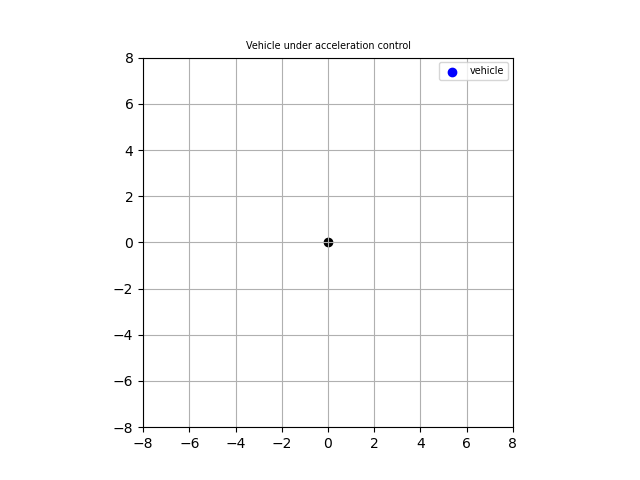

In [3]:
%matplotlib widget
#%matplotlib qt6

from ipyshow.odesimu.util import buffered
from functools import partial

class Target:
  period = 20
  @staticmethod
  def still(t,spot=array((7.,5.))): return spot
  @staticmethod
  def circle(t,R=4.,ω=2*pi/period):
    θ = ω*t
    return R*hstack((sin(θ),cos(θ)))
  @staticmethod
  def cycloid(t,R=4.,r=2.,l=-5.,ω=2*pi/period):
    θ = ω*t
    return R*hstack((sin(θ),cos(θ)))+r*hstack((sin(l*θ),cos(l*θ)))
  @staticmethod
  def buffered(f,_B=buffered(T=period,N=int(100*period)),*a,**ka): return _B(partial(f,*a,**ka))
  control = dict(
    N=2,
    gP=15.,
    #gI=2.,
    gD=5.,
    blur=.05,
  )

#target = Target.still
#target = Target.buffered(Target.circle)
target = Target.buffered(Target.cycloid,l=5.)

syst = PIDControlledVehicle(Target.control,target)
ini = dict(x=0.,y=0.,xʹ=0.,yʹ=0.)
R = syst.simulation(init_y=ini)
R.play(frame_per_stu=25,track_spec=60.,displayer_kw={'view_cfg':{'target':{'c':'r','marker':'o','s':10},'main':{'bounds':((-8.,-8.),(8.,8.))}}})